# NTU Global Research Programme - Human Emotion Analysis

## P300 WAVE DETECTION USING EMOTIV EPOC+ HEADSET

This notebook provides sample code for analyzing EEG data collected from the Emotiv Epoc+ Headset.

The dataset used has been anonymized. Nonetheless, it is not disclosed.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import mne
from IPython.display import *

import glob

from scipy import signal

import re

import mne
#from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
#from mne.viz.topomap import _prepare_topo_plot, plot_topomap
#from mne.decoding import CSP
from mne import pick_types

In [6]:
data = pd.read_csv('eeg_data.txt', sep = '\t',
                  usecols = ['SystemTimestamp (Epoc)','Af3 (Epoc)','F7 (Epoc)','F3 (Epoc)','FC5 (Epoc)','T7 (Epoc)',
                             'P7 (Epoc)','O1/Pz (Epoc)','O2 (Epoc)','P8 (Epoc)','T8 (Epoc)','FC6 (Epoc)','F4 (Epoc)',
                             'F8 (Epoc)','AF4 (Epoc)','StimulusName'])
# Remove all Instructions stimuli
data = data[data.StimulusName.isin([x for x in data.StimulusName.unique() if 'Instr' not in x])].dropna()
data = data.drop_duplicates(subset = 'SystemTimestamp (Epoc)').reset_index().drop('index', axis = 1)
# Rename columns
data.columns = ['StimulusName', 'Af3', 'F7', 'F3', 'FC5','T7', 'P7', 'O1', 'O2', 'P8','T8', 'FC6', 'F4', 'F8', 'AF4',
       'SystemTimestamp (Epoc)']

Data:

In [9]:
data.head()

,StimulusName,Af3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,SystemTimestamp (Epoc)
0,Alpha1,4177.307692,4183.076923,4175.769231,4193.717949,4159.358974,4164.358974,4165.384615,4174.615385,4154.871795,4152.051282,4111.025641,4131.153846,4137.051282,4110.769231,1480.126244
1,Alpha1,4175.000000,4176.282051,4172.820513,4189.230769,4150.384615,4159.230769,4164.102564,4172.307692,4147.692308,4144.487179,4108.076923,4131.410256,4131.282051,4105.897436,1480.128789
2,Alpha1,4182.179487,4182.051282,4171.923077,4193.333333,4157.051282,4163.717949,4163.974359,4173.589744,4154.871795,4156.282051,4120.128205,4138.589744,4142.564103,4114.358974,1480.131234
3,Alpha1,4185.769231,4185.897436,4173.333333,4196.666667,4163.333333,4166.153846,4163.846154,4174.743590,4161.153846,4166.410256,4127.435897,4143.076923,4152.307692,4120.769231,1480.133679
4,Alpha1,4180.512821,4179.743590,4175.384615,4191.666667,4158.589744,4160.384615,4163.333333,4175.384615,4156.794872,4160.128205,4119.230769,4139.230769,4147.564103,4114.615385,1480.136125


Plot topo graphs of EEG channels (1-20Hz filter):

Creating RawArray with float64 data, n_channels=14, n_times=78057
    Range : 0 ... 78056 =      0.000 ...   304.906 secs
Ready.
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 845 samples (3.301 sec) selected
Setting up low-pass filter at 20 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 169 samples (0.660 sec) selected
Effective window size : 8.000 (s)


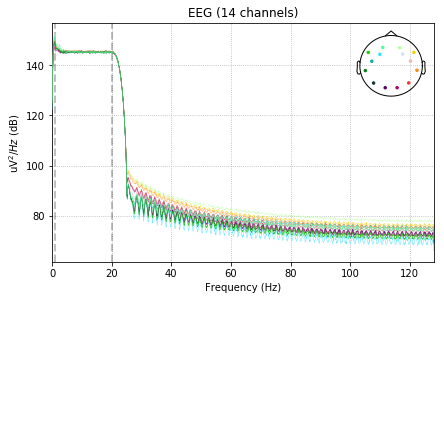

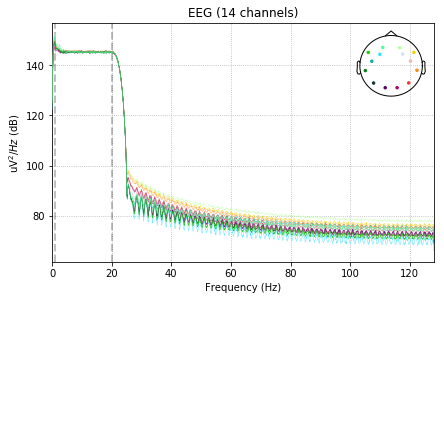

In [19]:
# Names for each channel
channel_names = ['Af3', 'F7', 'F3', 'FC5','T7', 'P7', 'O1', 'O2', 'P8','T8', 'FC6', 'F4', 'F8', 'AF4']

# The type (mag, grad, eeg, eog, misc, ...) of each channel
channel_types = ['eeg']*14

# The sampling rate of the recording
sfreq = 256  # in Hertz

# The EEG channels use the standard naming strategy.
# By supplying the 'montage' parameter, approximate locations
# will be added for them
montage = 'standard_1005'

# Initialize required fields
info = mne.create_info(channel_names, sfreq, channel_types, montage)

# Add some more information
info['description'] = 'Sample data'
#info['bads'] = ['Pz']  # Names of bad channels

data_array = np.array(data.loc[:,'Af3':'AF4']).T
# Initialize an info structure
raw = mne.io.RawArray(data_array, info)
picks = pick_types(raw.info,eeg=True)

# High pass filter at 1 Hz
raw.filter(l_freq = 1, h_freq = None, n_jobs=1, method='fir', fir_design='firwin', filter_length = 'auto')

# Low pass filter at 20 Hz
raw.filter(l_freq = None, h_freq = 20, n_jobs=1, method='fir', fir_design='firwin', filter_length = 'auto')

raw.plot_psd(area_mode='range', picks=picks, average=False)

Event-related potentials (ERPs):

Creating RawArray with float64 data, n_channels=1, n_times=78057
    Range : 0 ... 78056 =      0.000 ...   304.906 secs
Ready.
46 events found
Event IDs: [1 2 3 4 5]
43 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 43 events and 257 original time points ...
0 bad epochs dropped


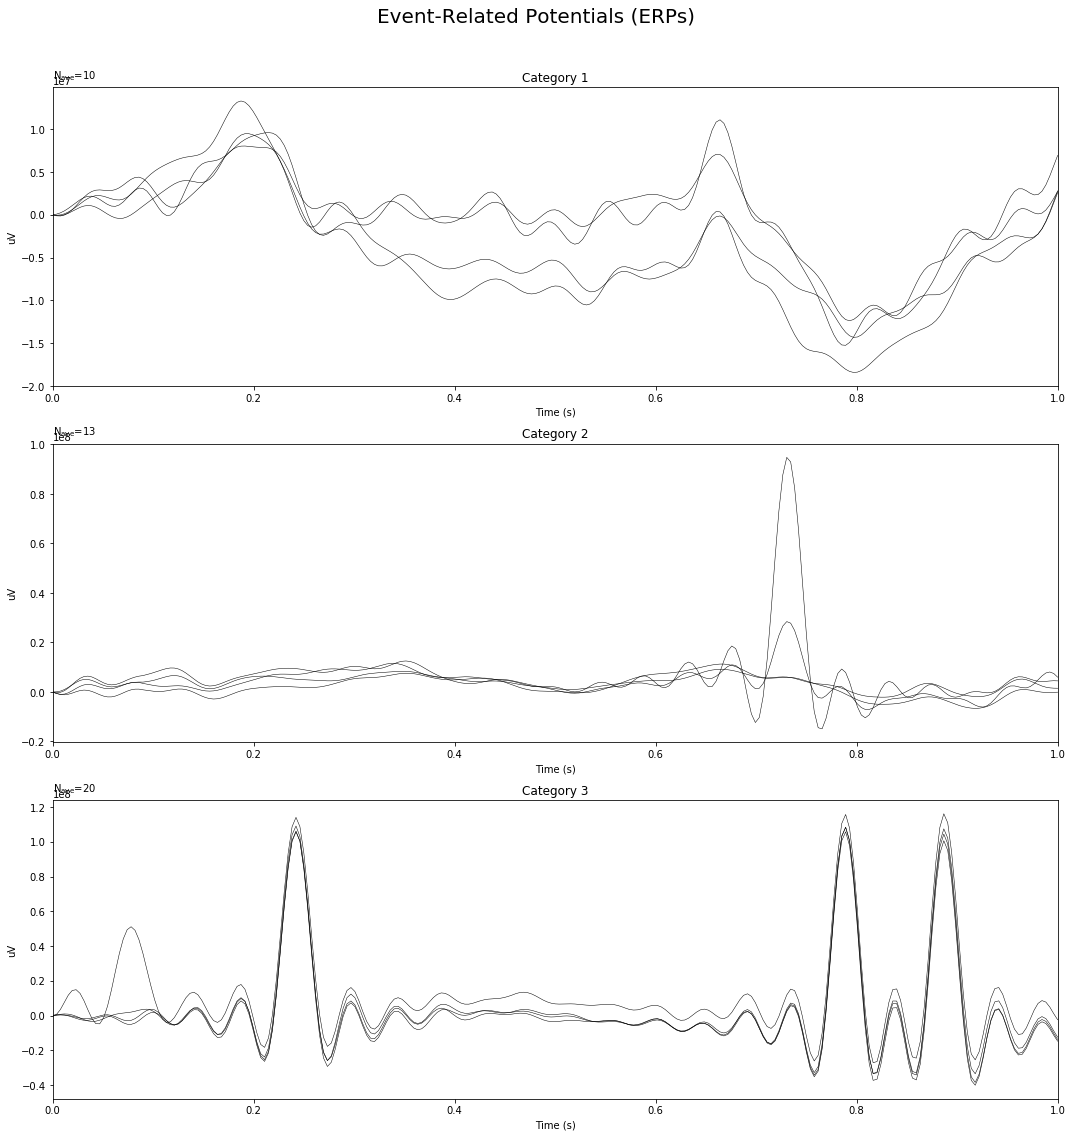

In [20]:
events = data[['StimulusName']]
events.StimulusName = events.StimulusName.apply(lambda x: ''.join(list(re.sub(r'([^a-zA-Z ]+?)', '', x))))
def group_stim(x):
    if x in ['Alpha','Gen']:
        return 'General questions'
    elif x in ['GenLie','Relevant']:
        return 'Relevant questions'
    elif x in ['JonSecretary','Wallet']:
        return 'Category 1'
    elif x in ['Room','Cup']:
        return 'Category 2'
    else:
        return 'Irrelevant'
def encode_event(x):
        if x == 'General questions':
            return 1
        elif x == 'Relevant questions':
            return 2
        elif x == 'Category 1':
            return 3
        elif x == 'Category 2':
            return 4
        else:
            return 5
events.StimulusName = events.StimulusName.apply(group_stim)
events.StimulusName = events.StimulusName.apply(encode_event)
events = events.reset_index()

info = mne.create_info(['STI'], raw.info['sfreq'], ['stim'])
stim_raw = mne.io.RawArray(np.array(events.StimulusName).reshape(1,len(events.StimulusName)), info)
raw.add_channels([stim_raw], force_update_info=True)

event_id = {'Cat1': 3,
            'Cat2': 4, 'Cat3': 5} #'GeneralQuestions': 1, 'RelevantQuestions': 2, 

events2 = mne.find_events(raw, stim_channel='STI', initial_event=True)

epochs = mne.Epochs(raw, events2, event_id, tmin=0, tmax=1,
                    baseline=(None,0), preload=True)
epochs.pick_channels(['P7','O1','O2','P8'])

ev_crime = epochs['Cat1'].average()
ev_scene = epochs['Cat2'].average()
ev_irrelevant = epochs['Cat3'].average()

f, axs = plt.subplots(3, 1, figsize=(15, 15), facecolor = 'white')
f.suptitle('Event-Related Potentials (ERPs)', fontsize=20, y = 1.05)
ev_crime.plot(axes=axs[0], show=False, time_unit='s')
axs[0].set_title('Category 1')
ev_scene.plot(axes=axs[1], show=False, time_unit='s')
axs[1].set_title('Category 2')
ev_irrelevant.plot(axes=axs[2], show=False, time_unit='s')
axs[2].set_title('Category 3')
plt.tight_layout()

Independent Component Analysis (ICA):

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by explained variance: 3 components
Fitting ICA took 0.3s.
<ICA  |  raw data decomposition, fit (fastica): 78057 samples, 3 components, channels used: "eeg">


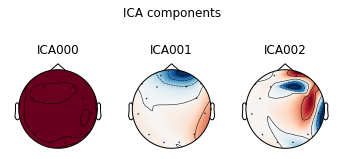

[<Figure size 352.8x180 with 3 Axes>]

In [26]:
import mne
from mne.preprocessing import ICA
#from mne.preprocessing import create_eog_epochs, create_ecg_epochs

method = 'fastica'


random_state = 23

ica = ICA(n_components=0.97, method=method, random_state=random_state)

ica.fit(raw, picks=mne.pick_types(raw.info, eeg = True, exclude=[]))
print(ica)
ica.plot_components()